# CSCI 3202, Spring 2022: Final Coding Project

---


This is your final programming project for CSCI 3202. It is due on Canvas by **11:59 PM on Saturday April 30**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

You have two options for completing your final project for this course. The first option is presented in this notebook and involves implementing a reinforcement learning algorithm and producing a five-minute video that explains your process of solving this problem. The second option is to design your own project that includes the algorithms we've discussed since the midterm - Bayes Nets, Hidden Markov Models, Markov Decision Processes, or Reinforcement Learning - or an algorithm related to one of these that we haven't discussed in class. Your project also needs to include some kind of analysis of how it performed on a specific problem. If you're interested in the design your own project option, you need to discuss your idea with one of the course instructors to get approval. If you do a project without getting approval, you will receive a 0 regardless of the quality of the project. You will also need to produce a short, five-minute video that explains your project.

**The rules:**

1. Choose EITHER the given problem to submit OR choose your own project topic. 

2. If you choose your own project topic, please adhere to the following guidelines:
- The project needs to be approved by the course instructors.
- The project needs to include one of the algorithms we've discussed since the midterm - Bayes Nets, HMMs, MDPs, or Reinforcement Learning - or an algorithm that we haven't discussed in class. 
- If you do your own project without prior approval, you will receive a 0 for this project.
- Your project code, explanation, and results must all be contained in a Jupyter notebook. 

3. All work, code and analysis must be **your own**.
4. You may use your course notes, posted lecture slides, textbook, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python. You may not use entire segments of code as solutions to any part of this project, e.g. if you find a Python implementation of policy iteration online, you can't use it.
5. You may **not** post to message boards or other online resources asking for help.
6. **You may not collaborate with classmates or anyone else.**
7. This is meant to be like a coding portion of your final exam. So, we will be much less helpful than we typically am with homework. For example, we will not check answers, help debug your code, and so on.
8. If you have a question, post it first as a **private** Piazza message. If we decide that it is appropriate for the entire class, then we will make it a public post (and anonymous).
9. If something is left open-ended, it is probably because we intend for you to code it up however you want, and only care about the plots/analysis we see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name: Téa Wright** 

---



In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
import copy as cp
import random
import operator

# added packages
import heapq
from matplotlib import colors



---
## [100 pts] Problem 1:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if the drone is at $(x,y,z)$ it means that the box is centered at $(x,y,z)$. There are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. For example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a living reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the landing pad is, and how to get there from any initial state.

Before moving on to Part B, we recommend that you test that your MDPLanding code is set up correctly. Write unit tests that display the actions for a given state, rewards, results, etc. This will help you identify errors in your implementation and save you a lot of debugging time later.

In [105]:
# transition probability = 1
class MDPLanding:
    
    def __init__(self, L):
        
        self.L = L
        
        x_initial = random.randrange(0,L+1)
        y_initial = random.randrange(0,L+1)
        z_initial = random.randrange(1,L+1) #cannot start in terminal state
        self.initial_state = (x_initial,y_initial,z_initial)
        
        
        self.default_reward = -0.01
        self.discount = 0.999
        self.goal = (L/2,L/2,0)
        
        self.all_actions = ["up","down","north","south","east","west"]
        self.states = [(x,y,z) for x in range(0,L+1) for y in range(0,L+1) for z in range(0,L+1)]
        self.terminal_states = [(x,y,0) for x in range(0,L+1) for y in range(0,L+1)]
    
    
    def restart(self):
        x_initial = random.randrange(0,self.L+1)
        y_initial = random.randrange(0,self.L+1)
        z_initial = random.randrange(1,self.L+1)
        return (x_initial,y_initial,z_initial)
        
    def actions(self,state):
        result = cp.copy(self.all_actions)
        if state[0] == 0:
             result.remove("west")
        elif state[0] == self.L:
            result.remove("east")
        
        if state[1] == 0:
            result.remove("south")
        if state[1] == self.L:
            result.remove("north")
        
        if state[2] == self.L:
            result.remove("up")
        if state[2] == 0:
            result.remove("down")
        
        return result
    
        
    def reward(self,state):
        if state[2]!=0:
            return self.default_reward
        elif state==self.goal:
            return 1
        else:
            return -1
        
        
    #other reward structures
    
    
    def reward1(self,state):
        if state[2] != 0:
            return( -(abs(self.goal[0]-state[0]) + abs(self.goal[1]-state[1]) + abs(self.goal[2]-state[2])))
        elif state==self.goal:
            return self.L*(5)
        else:
            return -(self.L*(5))
    def reward2(self,state):
        if state[2]!=0:
            return self.default_reward
        elif state==self.goal:
            return 100
        else:
            return -100
    def reward3(self,state):
        if state[2] != 0:
            return( -(abs(self.goal[0]-state[0]) + abs(self.goal[1]-state[1]) + abs(self.goal[2]-state[2]))/1000)
        elif state==self.goal:
            return 1
        else:
            return -1
    
    
    
    def result(self,state,action):
        if action not in self.actions(state): #check action can be done
            print("not a valid action")
            return
        else: 
            if action=="up":
                newstate = (state[0],state[1],state[2]+1)
            elif action=="down":
                newstate = (state[0],state[1],state[2]-1)
            elif action=="north":
                newstate = (state[0],state[1]+1,state[2])
            elif action=="south":
                newstate = (state[0],state[1]-1,state[2])
            elif action=="east":
                newstate = (state[0]+1,state[1],state[2])
            elif action=="west":
                 newstate = (state[0]-1,state[1],state[2])
        return newstate
    
    
    
    #extra added functions
    
    def actionToNum(self, action):
        if action in self.all_actions:
            return self.all_actions.index(action)
        
    def actionToStr(self,num):
        if num==0:
            return "up"
        if num==1:
            return "down"
        if num==2:
            return "north"
        if num==3:
            return "south"
        if num==4:
            return "east"
        if num==5:
            return "west"
    
        

In [92]:
#unit tests
test_m = MDPLanding(4)
print(test_m.initial_state)
print(test_m.actions((0,2,4)))

print(test_m.reward((2,2,2))==-0.01)
print(test_m.reward((2,2,0))==1)
print(test_m.reward((4,1,0))==-1)

print(test_m.result((2,2,2),"up"))

(3, 3, 1)
['down', 'north', 'south', 'east']
True
True
True
(2, 2, 3)


#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and **comment on the results**:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

The policy for each of these states is the action that the agent should take in that state. 

In [114]:
def policy_iteration(mdp):
    
    gamma = mdp.discount
    
    def policy_improvement(mdp, v):
        pi = {s:np.random.choice(mdp.actions(s)) for s in mdp.states}
        for s in mdp.states:
            sa = {a: 0 for a in mdp.actions(s)}
            for a in mdp.actions(s):
                s_ = mdp.result(s,a)  
                sa[a] = mdp.reward(s_) + gamma * v[s_]         
                pi[s] = max(sa.items(), key=operator.itemgetter(1))[0]
        return pi

    
    
    def policy_evaluation(mdp, pi): #evaluate bellman eqns
        v = {s:0 for s in mdp.states}
        epsilon = 0.001
        while True:
            prev_v = cp.copy(v)
            sum_diffs = 0
            for s in mdp.states:
                s_ = mdp.result(s,pi[s])
                v[s] = mdp.reward(s_) + gamma * prev_v[s_]
                sum_diffs += np.fabs(prev_v[s] - v[s])
            if (sum_diffs <= epsilon):
                break
        return v
    
    
        
    old_pi =  {s:np.random.choice(mdp.actions(s)) for s in mdp.states} # initialize a random policy
    max_iterations = 1000
    gamma = 0.9
    
    for i in range(max_iterations): #iterate through policies
        old_pi_v = policy_evaluation(mdp, old_pi)
        new_pi = policy_improvement(mdp, old_pi_v)
        if (np.all(old_pi == new_pi)):
            print ('Policy complete at iteration %d.' %(i+1))
            break
        old_pi = new_pi
        
    for s in mdp.states: #check for terminal state
        if s in mdp.terminal_states:
            new_pi[s]="terminal state(no policy)"
    return new_pi

In [115]:
optimal_policy = policy_iteration(MDPLanding(4))
for key, value in optimal_policy.items():
    print(key, ' : ', value)

Policy complete at iteration 9.
(0, 0, 0)  :  terminal state(no policy)
(0, 0, 1)  :  north
(0, 0, 2)  :  down
(0, 0, 3)  :  down
(0, 0, 4)  :  down
(0, 1, 0)  :  terminal state(no policy)
(0, 1, 1)  :  north
(0, 1, 2)  :  down
(0, 1, 3)  :  down
(0, 1, 4)  :  down
(0, 2, 0)  :  terminal state(no policy)
(0, 2, 1)  :  east
(0, 2, 2)  :  down
(0, 2, 3)  :  down
(0, 2, 4)  :  down
(0, 3, 0)  :  terminal state(no policy)
(0, 3, 1)  :  south
(0, 3, 2)  :  down
(0, 3, 3)  :  down
(0, 3, 4)  :  down
(0, 4, 0)  :  terminal state(no policy)
(0, 4, 1)  :  south
(0, 4, 2)  :  down
(0, 4, 3)  :  down
(0, 4, 4)  :  down
(1, 0, 0)  :  terminal state(no policy)
(1, 0, 1)  :  north
(1, 0, 2)  :  down
(1, 0, 3)  :  down
(1, 0, 4)  :  down
(1, 1, 0)  :  terminal state(no policy)
(1, 1, 1)  :  north
(1, 1, 2)  :  down
(1, 1, 3)  :  down
(1, 1, 4)  :  down
(1, 2, 0)  :  terminal state(no policy)
(1, 2, 1)  :  east
(1, 2, 2)  :  down
(1, 2, 3)  :  down
(1, 2, 4)  :  down
(1, 3, 0)  :  terminal state(no po

I would expect (2,2,1) to be down, (0,2,1) to be east, and (2,0,1) to be north. These all match up with my results. Generally, the policy starts with the z value, moving the drone down to z=1 for any given state. Then, it adjusts the y values, bringing the drone to y=2. The policy then moves the drone east/west to x=2, so it is at (2,2,1) before finally moving down and landing the drone.   

#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values.  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. We refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets in Part D below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [110]:
def q_learn(mdp,num_episodes,num_steps):
    alpha = 0.97
    gamma = mdp.discount
    epsilon = 0.9999
    num_actions = 6
    cumulative_rewards = []

    # initialize Q table
    Q = {s:np.ones(num_actions) for s in mdp.states}


    def greedy_e(Q,state):  #greedy epsilon
        n = random.uniform(0, 1)
        if n > epsilon:
            action_str = random.choice(mdp.actions(state))
            action = mdp.actionToNum(action_str)
        else: 
            actions_by_best = sorted(enumerate(Q[state]), key=lambda x:x[1], reverse=True) #make sure action is valid
            action = actions_by_best.pop(0)[0]
            while mdp.actionToStr(action) not in mdp.actions(state):
                action = actions_by_best.pop(0)[0]
        return action
         
    for episode in range(num_episodes):
        
        state = mdp.restart()
        cumulative_reward = 0
        action = greedy_e(Q,state)
        
        for step in range(num_steps):
            next_state = mdp.result(state,mdp.actionToStr(action))
            next_action = greedy_e(Q,next_state)
            reward = mdp.reward(next_state)
            cumulative_reward += reward
            if next_state in mdp.terminal_states: #if reached terminal state, exit loop and return
                Q[state][action] += alpha * (reward  - Q[state][action])
                break
            Q[state][action] += alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]) #temporal difference
            state = next_state
            action = next_action
        cumulative_rewards.append(cumulative_reward)
    
        
    return Q,cumulative_rewards


#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your code.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

cumulative reward across the last 5000 training trials: 0.8991239999999919
[-0.61792, -0.049920000000000145, 0.52194, 0.73546, 0.8111399999999999, 0.8529399999999999, 0.8741399999999999, 0.8898400000000001, 0.88848, 0.8939000000000001, 0.8991199999999999, 0.8966000000000001, 0.8993399999999999, 0.8999400000000001, 0.89824, 0.89982, 0.89942, 0.8965, 0.9012, 0.90106]


Text(0, 0.5, 'Block Cumulative Reward Means')

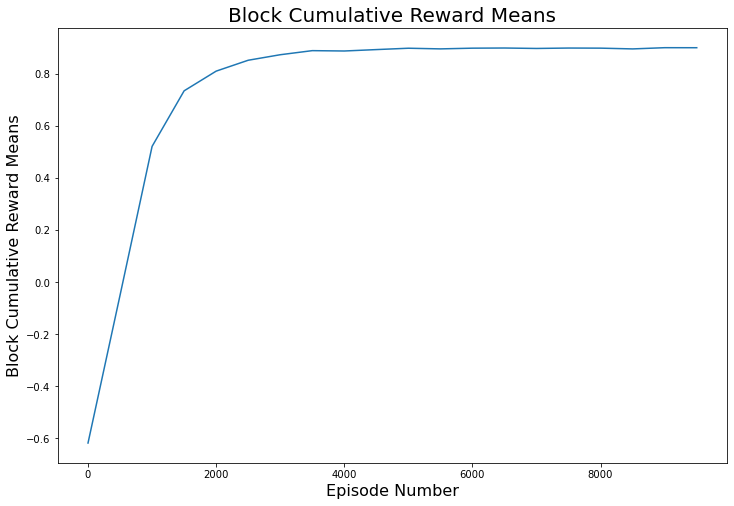

In [111]:
#cumulative reward check
result = q_learn(MDPLanding(10),10000,50)
cumulative_rewards = result[1]
sum = 0
for i in range(5000,10000):
    sum += cumulative_rewards[i]
print("cumulative reward across the last 5000 training trials:",sum/5000)

#block means
block_size = 500
blocks = [cumulative_rewards[n:n+block_size] for n in range(0, len(cumulative_rewards), block_size)]
i = 0
block_means = []
for i in range(20):
    block_mean = np.mean(blocks[i])
    block_means.append(block_mean)
print(block_means)



#plot
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(range(0,10000,500),block_means)
ax.set_title("Block Cumulative Reward Means",fontsize=20)
ax.set_xlabel("Episode Number",fontsize=16)
ax.set_ylabel("Block Cumulative Reward Means",fontsize=16)

#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?

Since the reward of living states is -0.01 and the drone is unlikely to find it's way to a terminal state, the reward of each time step will be -0.01. Then, since we capped the timesteps at 50, the cumulative reward will be -0.5. Of course there will be exceptions that find terminal states, but they will not affect the average much.

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?

Becuase the drone must first make it's way to the goal from a random start point, every move from there to the goal will add -0.01 to the cumulative reward. By the time the drone reaches the goal with reward 1, it will have accumulated roughly 20 living rewards on the way. 20 is how far the drone is from the goal in the space for every restart. Sometimes, the drone may be able to make it to the goal in only 5 steps, with a cumulative reward of .95, and, at worst, it takes closer to 20.

#### Part F
Choose three other reward structures, including the terminal rewards and the living rewards, and rerun your policy iteration and Q-learning algorithms with those reward structures. Write a paragraph or two describing the reward structures that you selected, what impact you expected the changes to have on your results, and what changes actually happened. If there was a difference in what you expected and what actually happened, reflect on why there was a difference. 

**Reward Structure 1:**

In [87]:
def policy_iteration1(mdp):
    
    gamma = mdp.discount
    
    def policy_improvement(mdp, v):
        pi = {s:np.random.choice(mdp.actions(s)) for s in mdp.states}
        for s in mdp.states:
            q_sa = {a: 0 for a in mdp.actions(s)}
            for a in mdp.actions(s):
                s_ = mdp.result(s,a)  
                q_sa[a] = mdp.reward1(s_) + gamma * v[s_]         
                pi[s] = max(q_sa.items(), key=operator.itemgetter(1))[0]
        return pi

    
    
    def policy_evaluation(mdp, pi): #evaluate bellman eqns
        v = {s:0 for s in mdp.states}
        epsilon = 0.001
        while True:
            prev_v = cp.copy(v)
            sum_diffs = 0
            for s in mdp.states:
                s_ = mdp.result(s,pi[s])
                v[s] = mdp.reward1(s_) + gamma * prev_v[s_]
                sum_diffs += np.fabs(prev_v[s] - v[s])
            if (sum_diffs <= epsilon):
                break
        return v
    
    
        
    old_pi =  {s:np.random.choice(mdp.actions(s)) for s in mdp.states} # initialize a random policy
    max_iterations = 1000
    gamma = 0.9
    for i in range(max_iterations):
        old_pi_v = policy_evaluation(mdp, old_pi)
        #print('old_policy', old_pi)
        new_pi = policy_improvement(mdp, old_pi_v)
        #print('new_policy', new_pi)
        #print()
        if (np.all(old_pi == new_pi)):
            print ('Policy-Iteration converged at step %d.' %(i+1))
            break
        old_pi = new_pi
        
    for s in mdp.states:
        if s in mdp.terminal_states:
            new_pi[s]="terminal state(no policy)"
    return new_pi

In [88]:
optimal_policy = policy_iteration1(MDPLanding(4))
for key, value in optimal_policy.items():
    print(key, ' : ', value)

Policy-Iteration converged at step 4.
(0, 0, 0)  :  terminal state(no policy)
(0, 0, 1)  :  north
(0, 0, 2)  :  down
(0, 0, 3)  :  down
(0, 0, 4)  :  down
(0, 1, 0)  :  terminal state(no policy)
(0, 1, 1)  :  north
(0, 1, 2)  :  down
(0, 1, 3)  :  down
(0, 1, 4)  :  down
(0, 2, 0)  :  terminal state(no policy)
(0, 2, 1)  :  east
(0, 2, 2)  :  down
(0, 2, 3)  :  down
(0, 2, 4)  :  down
(0, 3, 0)  :  terminal state(no policy)
(0, 3, 1)  :  south
(0, 3, 2)  :  down
(0, 3, 3)  :  down
(0, 3, 4)  :  down
(0, 4, 0)  :  terminal state(no policy)
(0, 4, 1)  :  south
(0, 4, 2)  :  down
(0, 4, 3)  :  down
(0, 4, 4)  :  down
(1, 0, 0)  :  terminal state(no policy)
(1, 0, 1)  :  north
(1, 0, 2)  :  down
(1, 0, 3)  :  down
(1, 0, 4)  :  down
(1, 1, 0)  :  terminal state(no policy)
(1, 1, 1)  :  north
(1, 1, 2)  :  down
(1, 1, 3)  :  down
(1, 1, 4)  :  down
(1, 2, 0)  :  terminal state(no policy)
(1, 2, 1)  :  east
(1, 2, 2)  :  down
(1, 2, 3)  :  down
(1, 2, 4)  :  down
(1, 3, 0)  :  terminal state

In [89]:
def q_learn1(mdp,num_episodes,num_steps):
    alpha = 0.97
    gamma = mdp.discount
    epsilon = 0.9999
    num_actions = 6
    cumulative_rewards = []

    # initialize Q table
    #Q = {s:np.zeros(num_actions) for s in mdp.states}
    Q = {s:np.ones(num_actions) for s in mdp.states}


    def greedy_e(Q,state):
        n = random.uniform(0, 1)
        if n > epsilon:
            action_str = random.choice(mdp.actions(state))
            action = mdp.actionToNum(action_str)
        else:
            actions_by_best = sorted(enumerate(Q[state]), key=lambda x:x[1], reverse=True)
            action = actions_by_best.pop(0)[0]
            while mdp.actionToStr(action) not in mdp.actions(state):
                action = actions_by_best.pop(0)[0]
        return action
         
    for episode in range(num_episodes):
        state = mdp.restart()
        cumulative_reward = 0
        average_reward = 0
        action = greedy_e(Q,state)
        for step in range(num_steps):
            next_state = mdp.result(state,mdp.actionToStr(action))
            next_action = greedy_e(Q,next_state)
            reward = mdp.reward1(next_state)
            cumulative_reward += reward
            if next_state in mdp.terminal_states:
                Q[state][action] += alpha * (reward  - Q[state][action])
                break
            Q[state][action] += alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action])
            state = next_state
            action = next_action
        cumulative_rewards.append(cumulative_reward)
    
        
    return Q,cumulative_rewards

cumulative reward across the last 5000 training trials: -16.1572
[-276.776, -98.012, -51.462, -33.53, -23.214, -23.322, -21.468, -20.858, -22.08, -20.926, -15.33, -14.29, -17.486, -15.816, -16.752, -19.628, -13.478, -15.844, -17.874, -15.074]


Text(0, 0.5, 'Block Cumulative Reward Means')

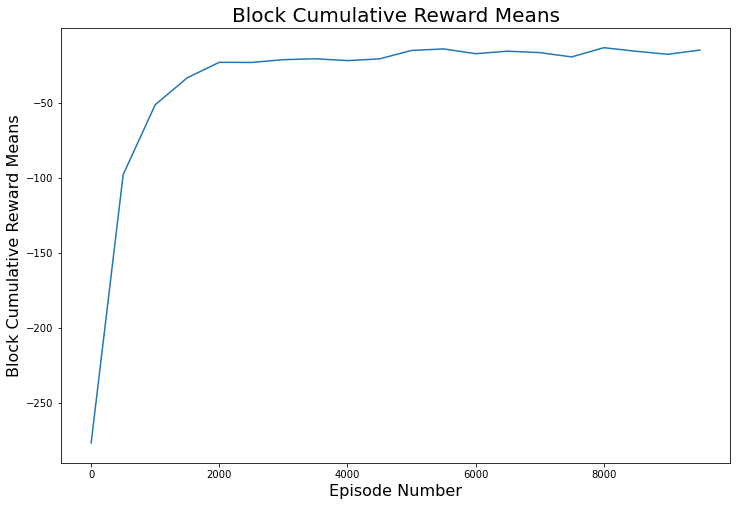

In [90]:
#cumulative reward check
result = q_learn1(MDPLanding(10),10000,50)
cumulative_rewards = result[1]
sum = 0
for i in range(5000,10000):
    sum += cumulative_rewards[i]
print("cumulative reward across the last 5000 training trials:",sum/5000)

#block means
block_size = 500
blocks = [cumulative_rewards[n:n+block_size] for n in range(0, len(cumulative_rewards), block_size)]
i = 0
block_means = []
for i in range(20):
    block_mean = np.mean(blocks[i])
    block_means.append(block_mean)
print(block_means)



#plot
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(range(0,10000,500),block_means)
ax.set_title("Block Cumulative Reward Means",fontsize=20)
ax.set_xlabel("Episode Number",fontsize=16)
ax.set_ylabel("Block Cumulative Reward Means",fontsize=16)

**Reward Structure 2:**

In [93]:
def policy_iteration2(mdp):
    
    gamma = mdp.discount
    
    def policy_improvement(mdp, v):
        pi = {s:np.random.choice(mdp.actions(s)) for s in mdp.states}
        for s in mdp.states:
            q_sa = {a: 0 for a in mdp.actions(s)}
            for a in mdp.actions(s):
                s_ = mdp.result(s,a)  
                q_sa[a] = mdp.reward2(s_) + gamma * v[s_]         
                pi[s] = max(q_sa.items(), key=operator.itemgetter(1))[0]
        return pi

    
    
    def policy_evaluation(mdp, pi): #evaluate bellman eqns
        v = {s:0 for s in mdp.states}
        epsilon = 0.001
        while True:
            prev_v = cp.copy(v)
            sum_diffs = 0
            for s in mdp.states:
                s_ = mdp.result(s,pi[s])
                v[s] = mdp.reward2(s_) + gamma * prev_v[s_]
                sum_diffs += np.fabs(prev_v[s] - v[s])
            if (sum_diffs <= epsilon):
                break
        return v
    
    
        
    old_pi =  {s:np.random.choice(mdp.actions(s)) for s in mdp.states} # initialize a random policy
    max_iterations = 1000
    gamma = 0.9
    for i in range(max_iterations):
        old_pi_v = policy_evaluation(mdp, old_pi)
        #print('old_policy', old_pi)
        new_pi = policy_improvement(mdp, old_pi_v)
        #print('new_policy', new_pi)
        #print()
        if (np.all(old_pi == new_pi)):
            print ('Policy-Iteration converged at step %d.' %(i+1))
            break
        old_pi = new_pi
        
    for s in mdp.states:
        if s in mdp.terminal_states:
            new_pi[s]="terminal state(no policy)"
    return new_pi

In [94]:
optimal_policy = policy_iteration2(MDPLanding(4))
for key, value in optimal_policy.items():
    print(key, ' : ', value)

Policy-Iteration converged at step 7.
(0, 0, 0)  :  terminal state(no policy)
(0, 0, 1)  :  north
(0, 0, 2)  :  down
(0, 0, 3)  :  down
(0, 0, 4)  :  down
(0, 1, 0)  :  terminal state(no policy)
(0, 1, 1)  :  north
(0, 1, 2)  :  down
(0, 1, 3)  :  down
(0, 1, 4)  :  down
(0, 2, 0)  :  terminal state(no policy)
(0, 2, 1)  :  east
(0, 2, 2)  :  down
(0, 2, 3)  :  down
(0, 2, 4)  :  down
(0, 3, 0)  :  terminal state(no policy)
(0, 3, 1)  :  south
(0, 3, 2)  :  down
(0, 3, 3)  :  down
(0, 3, 4)  :  down
(0, 4, 0)  :  terminal state(no policy)
(0, 4, 1)  :  south
(0, 4, 2)  :  down
(0, 4, 3)  :  down
(0, 4, 4)  :  down
(1, 0, 0)  :  terminal state(no policy)
(1, 0, 1)  :  north
(1, 0, 2)  :  down
(1, 0, 3)  :  down
(1, 0, 4)  :  down
(1, 1, 0)  :  terminal state(no policy)
(1, 1, 1)  :  north
(1, 1, 2)  :  down
(1, 1, 3)  :  down
(1, 1, 4)  :  down
(1, 2, 0)  :  terminal state(no policy)
(1, 2, 1)  :  east
(1, 2, 2)  :  down
(1, 2, 3)  :  down
(1, 2, 4)  :  down
(1, 3, 0)  :  terminal state

In [95]:
def q_learn2(mdp,num_episodes,num_steps):
    alpha = 0.97
    gamma = mdp.discount
    epsilon = 0.9999
    num_actions = 6
    cumulative_rewards = []

    # initialize Q table
    #Q = {s:np.zeros(num_actions) for s in mdp.states}
    Q = {s:np.ones(num_actions) for s in mdp.states}


    def greedy_e(Q,state):
        n = random.uniform(0, 1)
        if n > epsilon:
            action_str = random.choice(mdp.actions(state))
            action = mdp.actionToNum(action_str)
        else:
            actions_by_best = sorted(enumerate(Q[state]), key=lambda x:x[1], reverse=True)
            action = actions_by_best.pop(0)[0]
            while mdp.actionToStr(action) not in mdp.actions(state):
                action = actions_by_best.pop(0)[0]
        return action
         
    for episode in range(num_episodes):
        state = mdp.restart()
        cumulative_reward = 0
        average_reward = 0
        action = greedy_e(Q,state)
        for step in range(num_steps):
            next_state = mdp.result(state,mdp.actionToStr(action))
            next_action = greedy_e(Q,next_state)
            reward = mdp.reward2(next_state)
            cumulative_reward += reward
            if next_state in mdp.terminal_states:
                Q[state][action] += alpha * (reward  - Q[state][action])
                break
            Q[state][action] += alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action])
            state = next_state
            action = next_action
        cumulative_rewards.append(cumulative_reward)
    
        
    return Q,cumulative_rewards

cumulative reward across the last 5000 training trials: 99.88497400000004
[-23.013260000000002, 54.26428, 94.6255, 99.6685, 99.88088, 99.87998000000002, 99.88672, 99.88592000000001, 99.88508, 99.88238, 99.88189999999999, 99.8871, 99.88444, 99.88526, 99.88564000000001, 99.88239999999999, 99.88832000000001, 99.8817, 99.88408, 99.88889999999999]


Text(0, 0.5, 'Block Cumulative Reward Means')

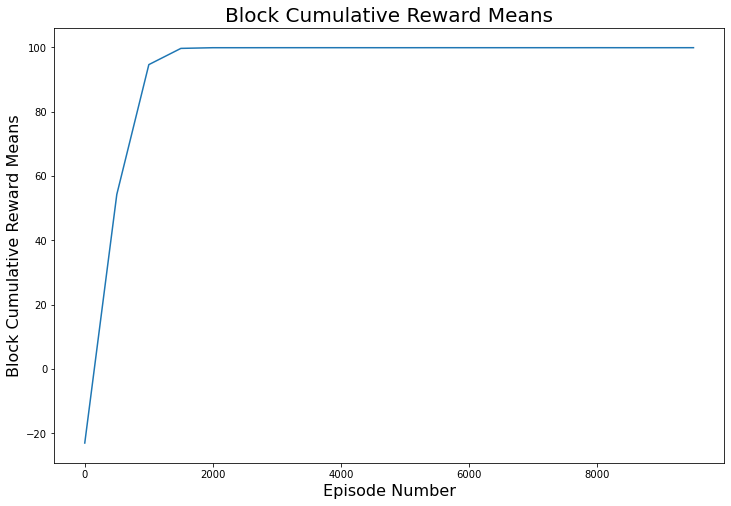

In [97]:
#cumulative reward check
result = q_learn2(MDPLanding(10),10000,50)
cumulative_rewards = result[1]
sum = 0
for i in range(5000,10000):
    sum += cumulative_rewards[i]
print("cumulative reward across the last 5000 training trials:",sum/5000)

#block means
block_size = 500
blocks = [cumulative_rewards[n:n+block_size] for n in range(0, len(cumulative_rewards), block_size)]
i = 0
block_means = []
for i in range(20):
    block_mean = np.mean(blocks[i])
    block_means.append(block_mean)
print(block_means)



#plot
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(range(0,10000,500),block_means)
ax.set_title("Block Cumulative Reward Means",fontsize=20)
ax.set_xlabel("Episode Number",fontsize=16)
ax.set_ylabel("Block Cumulative Reward Means",fontsize=16)

**Reward Structure 3:**

In [106]:
def policy_iteration3(mdp):
    
    gamma = mdp.discount
    
    def policy_improvement(mdp, v):
        pi = {s:np.random.choice(mdp.actions(s)) for s in mdp.states}
        for s in mdp.states:
            q_sa = {a: 0 for a in mdp.actions(s)}
            for a in mdp.actions(s):
                s_ = mdp.result(s,a)  
                q_sa[a] = mdp.reward3(s_) + gamma * v[s_]         
                pi[s] = max(q_sa.items(), key=operator.itemgetter(1))[0]
        return pi

    
    
    def policy_evaluation(mdp, pi): #evaluate bellman eqns
        v = {s:0 for s in mdp.states}
        epsilon = 0.001
        while True:
            prev_v = cp.copy(v)
            sum_diffs = 0
            for s in mdp.states:
                s_ = mdp.result(s,pi[s])
                v[s] = mdp.reward3(s_) + gamma * prev_v[s_]
                sum_diffs += np.fabs(prev_v[s] - v[s])
            if (sum_diffs <= epsilon):
                break
        return v
    
    
        
    old_pi =  {s:np.random.choice(mdp.actions(s)) for s in mdp.states} # initialize a random policy
    max_iterations = 1000
    gamma = 0.9
    for i in range(max_iterations):
        old_pi_v = policy_evaluation(mdp, old_pi)
        #print('old_policy', old_pi)
        new_pi = policy_improvement(mdp, old_pi_v)
        #print('new_policy', new_pi)
        #print()
        if (np.all(old_pi == new_pi)):
            print ('Policy-Iteration converged at step %d.' %(i+1))
            break
        old_pi = new_pi
        
    for s in mdp.states:
        if s in mdp.terminal_states:
            new_pi[s]="terminal state(no policy)"
    return new_pi

In [107]:
optimal_policy = policy_iteration3(MDPLanding(4))
for key, value in optimal_policy.items():
    print(key, ' : ', value)

Policy-Iteration converged at step 4.
(0, 0, 0)  :  terminal state(no policy)
(0, 0, 1)  :  north
(0, 0, 2)  :  down
(0, 0, 3)  :  down
(0, 0, 4)  :  down
(0, 1, 0)  :  terminal state(no policy)
(0, 1, 1)  :  north
(0, 1, 2)  :  down
(0, 1, 3)  :  down
(0, 1, 4)  :  down
(0, 2, 0)  :  terminal state(no policy)
(0, 2, 1)  :  east
(0, 2, 2)  :  down
(0, 2, 3)  :  down
(0, 2, 4)  :  down
(0, 3, 0)  :  terminal state(no policy)
(0, 3, 1)  :  south
(0, 3, 2)  :  down
(0, 3, 3)  :  down
(0, 3, 4)  :  down
(0, 4, 0)  :  terminal state(no policy)
(0, 4, 1)  :  south
(0, 4, 2)  :  down
(0, 4, 3)  :  down
(0, 4, 4)  :  down
(1, 0, 0)  :  terminal state(no policy)
(1, 0, 1)  :  north
(1, 0, 2)  :  down
(1, 0, 3)  :  down
(1, 0, 4)  :  down
(1, 1, 0)  :  terminal state(no policy)
(1, 1, 1)  :  north
(1, 1, 2)  :  down
(1, 1, 3)  :  down
(1, 1, 4)  :  down
(1, 2, 0)  :  terminal state(no policy)
(1, 2, 1)  :  east
(1, 2, 2)  :  down
(1, 2, 3)  :  down
(1, 2, 4)  :  down
(1, 3, 0)  :  terminal state

In [108]:
def q_learn3(mdp,num_episodes,num_steps):
    alpha = 0.97
    gamma = mdp.discount
    epsilon = 0.9999
    num_actions = 6
    cumulative_rewards = []

    # initialize Q table
    #Q = {s:np.zeros(num_actions) for s in mdp.states}
    Q = {s:np.ones(num_actions) for s in mdp.states}


    def greedy_e(Q,state):
        n = random.uniform(0, 1)
        if n > epsilon:
            action_str = random.choice(mdp.actions(state))
            action = mdp.actionToNum(action_str)
        else:
            actions_by_best = sorted(enumerate(Q[state]), key=lambda x:x[1], reverse=True)
            action = actions_by_best.pop(0)[0]
            while mdp.actionToStr(action) not in mdp.actions(state):
                action = actions_by_best.pop(0)[0]
        return action
         
    for episode in range(num_episodes):
        state = mdp.restart()
        cumulative_reward = 0
        average_reward = 0
        action = greedy_e(Q,state)
        for step in range(num_steps):
            next_state = mdp.result(state,mdp.actionToStr(action))
            next_action = greedy_e(Q,next_state)
            reward = mdp.reward3(next_state)
            cumulative_reward += reward
            if next_state in mdp.terminal_states:
                Q[state][action] += alpha * (reward  - Q[state][action])
                break
            Q[state][action] += alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action])
            state = next_state
            action = next_action
        cumulative_rewards.append(cumulative_reward)
    
        
    return Q,cumulative_rewards

cumulative reward across the last 5000 training trials: 0.9359852000000072
[-0.2948000000000002, 0.5744319999999998, 0.8107679999999999, 0.888404, 0.8972899999999999, 0.917368, 0.922766, 0.923142, 0.925114, 0.9304880000000001, 0.9335460000000001, 0.933644, 0.9323239999999999, 0.939894, 0.937136, 0.934844, 0.9327840000000001, 0.9394379999999999, 0.9389480000000001, 0.937294]


Text(0, 0.5, 'Block Cumulative Reward Means')

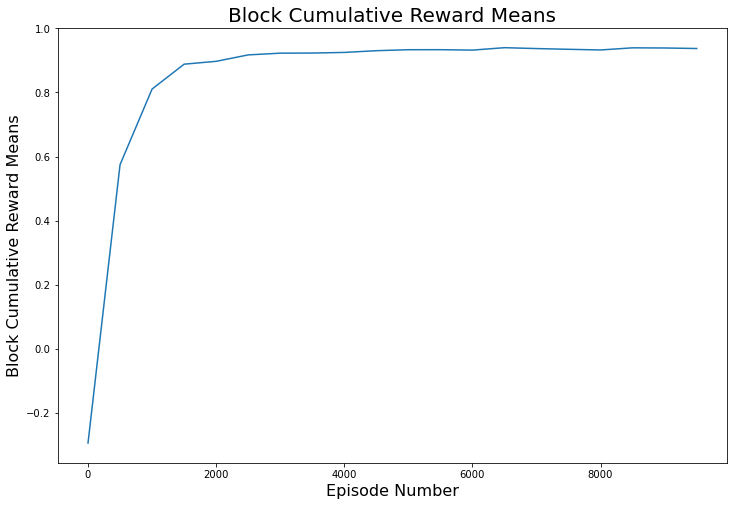

In [109]:
#cumulative reward check
result = q_learn3(MDPLanding(10),10000,50)
cumulative_rewards = result[1]
sum = 0
for i in range(5000,10000):
    sum += cumulative_rewards[i]
print("cumulative reward across the last 5000 training trials:",sum/5000)

#block means
block_size = 500
blocks = [cumulative_rewards[n:n+block_size] for n in range(0, len(cumulative_rewards), block_size)]
i = 0
block_means = []
for i in range(20):
    block_mean = np.mean(blocks[i])
    block_means.append(block_mean)
print(block_means)


#plot
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(range(0,10000,500),block_means)
ax.set_title("Block Cumulative Reward Means",fontsize=20)
ax.set_xlabel("Episode Number",fontsize=16)
ax.set_ylabel("Block Cumulative Reward Means",fontsize=16)

The first reward structure I selected takes a more gradual approach. Each living reward is the sum of the distances in each directtion from the goal made negative. The terminal non-goal rewards are large negative numbers(I chose 5 times the length). Since these rewards do guide the algorithms in the right direction still, I expected the policy to stay the same. I also expected improvement in Q-learning, but I did not think the results would be as good as with the initial reward stucture. My first belief was correct, but the Q-learning was successful despite negative rewards The policy remained the same, but Q-learning was not as good. Since the living rewards are much larger than -0.01, even if the drone reaches the goal, the rewards remain negative. However, the drone still learns and reaches the goal state most times, so it accomplishes its main objective, even if the rewards are low. I had not thought about the fact that the rewards would be negative, but, since it is relative, the drone still reaches the goal. Nonetheless,it did seem less consisten once it reaches higher cumulative reward values. There are two aspects of this reward structure working against eachother. While a gradient reward structure usually helps, having negative living rewards can cause the agent to terminate instead of accumulating more, so I think the negative living rewards could have harmed the gradient reward system.

The second structure I used simply made the terminal rewards much more dramatic. Rather than using -1 and 1, I used -100 and 100. Again, since the rewards are still pointing the drone to the goal and it is not much different from the initial reward structure, I did not expect the policy to change. Since the rewards/penalties are more drastic, Q-learning should learn faster once a few terminal states are reached randomly. My predictions in this case were correct. The policy stays the same. and the cumulative reward values in my plot for Q-learning get close to their max around episode 1000, rather than, with the initial reward structure, around 2000.


My last reward structure is similar to the first I used, but with the living rewards made much smaller and the terminal rewards the same as the original reward structure. This way, the inconsistency from large negative rewards found in the first reward structure no longer affects the result. The policy stays the same, as I would have guessed. Since the larger, negative rewards will no longer force early termination, I expected the Q-learning agent to reach that 0.8 threshold sooner. The slope of the plot is steeper, indicating the agent learned more quickly than with the first reward structure. Furthermore, the cumulative reward for the last 5000 trials was over 0.9, even better than my original Q-learning agent. This indicates that a gradient reward structure is most effective if executed properly. 